### Inferential Statistics

In [1]:
import json
import requests
import pandas as pd
from pandas.io.json import json_normalize 

dictionary = pd.read_csv('data/MELBOURNE_HOUSE_PRICES_LESS.csv')
main       = pd.read_csv("data/Melbourne_housing_FULL.csv")
dict_df = pd.DataFrame.from_dict(dictionary, orient='columns', dtype=None)
main_df = pd.DataFrame.from_dict(main, orient='columns', dtype=None)
print(main_df.info())
print(main_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34857 entries, 0 to 34856
Data columns (total 21 columns):
Suburb           34857 non-null object
Address          34857 non-null object
Rooms            34857 non-null int64
Type             34857 non-null object
Price            27247 non-null float64
Method           34857 non-null object
SellerG          34857 non-null object
Date             34857 non-null object
Distance         34856 non-null float64
Postcode         34856 non-null float64
Bedroom2         26640 non-null float64
Bathroom         26631 non-null float64
Car              26129 non-null float64
Landsize         23047 non-null float64
BuildingArea     13742 non-null float64
YearBuilt        15551 non-null float64
CouncilArea      34854 non-null object
Lattitude        26881 non-null float64
Longtitude       26881 non-null float64
Regionname       34854 non-null object
Propertycount    34854 non-null float64
dtypes: float64(12), int64(1), object(8)
memory usage: 5.6+ M

In [83]:
# Segregating the features that have an influence on the price.
features = main_df[['Suburb','Rooms','Price','Postcode','Bedroom2','Bathroom','Car','Landsize','CouncilArea']].copy()
print(features.head())

print(features.describe())

       Suburb  Rooms      Price  Postcode  Bedroom2  Bathroom  Car  Landsize  \
0  Abbotsford      2        NaN    3067.0       2.0       1.0  1.0     126.0   
1  Abbotsford      2  1480000.0    3067.0       2.0       1.0  1.0     202.0   
2  Abbotsford      2  1035000.0    3067.0       2.0       1.0  0.0     156.0   
3  Abbotsford      3        NaN    3067.0       3.0       2.0  1.0       0.0   
4  Abbotsford      3  1465000.0    3067.0       3.0       2.0  0.0     134.0   

          CouncilArea  
0  Yarra City Council  
1  Yarra City Council  
2  Yarra City Council  
3  Yarra City Council  
4  Yarra City Council  
              Rooms         Price      Postcode      Bedroom2      Bathroom  \
count  34857.000000  2.724700e+04  34856.000000  26640.000000  26631.000000   
mean       3.031012  1.050173e+06   3116.062859      3.084647      1.624798   
std        0.969933  6.414671e+05    109.023903      0.980690      0.724212   
min        1.000000  8.500000e+04   3000.000000      0.0000

In [84]:
#### Rather than performing the imputation, we can remove the records that NAN price
features = features.dropna(subset=['Price'])
#features = features[features['Landsize'] < 2000] 
#features = features[features['Price'] < 2000000] 
#features = features[features['Rooms'] < 8]
print(features.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27247 entries, 1 to 34856
Data columns (total 9 columns):
Suburb         27247 non-null object
Rooms          27247 non-null int64
Price          27247 non-null float64
Postcode       27246 non-null float64
Bedroom2       20806 non-null float64
Bathroom       20800 non-null float64
Car            20423 non-null float64
Landsize       17982 non-null float64
CouncilArea    27244 non-null object
dtypes: float64(6), int64(1), object(2)
memory usage: 2.1+ MB
None


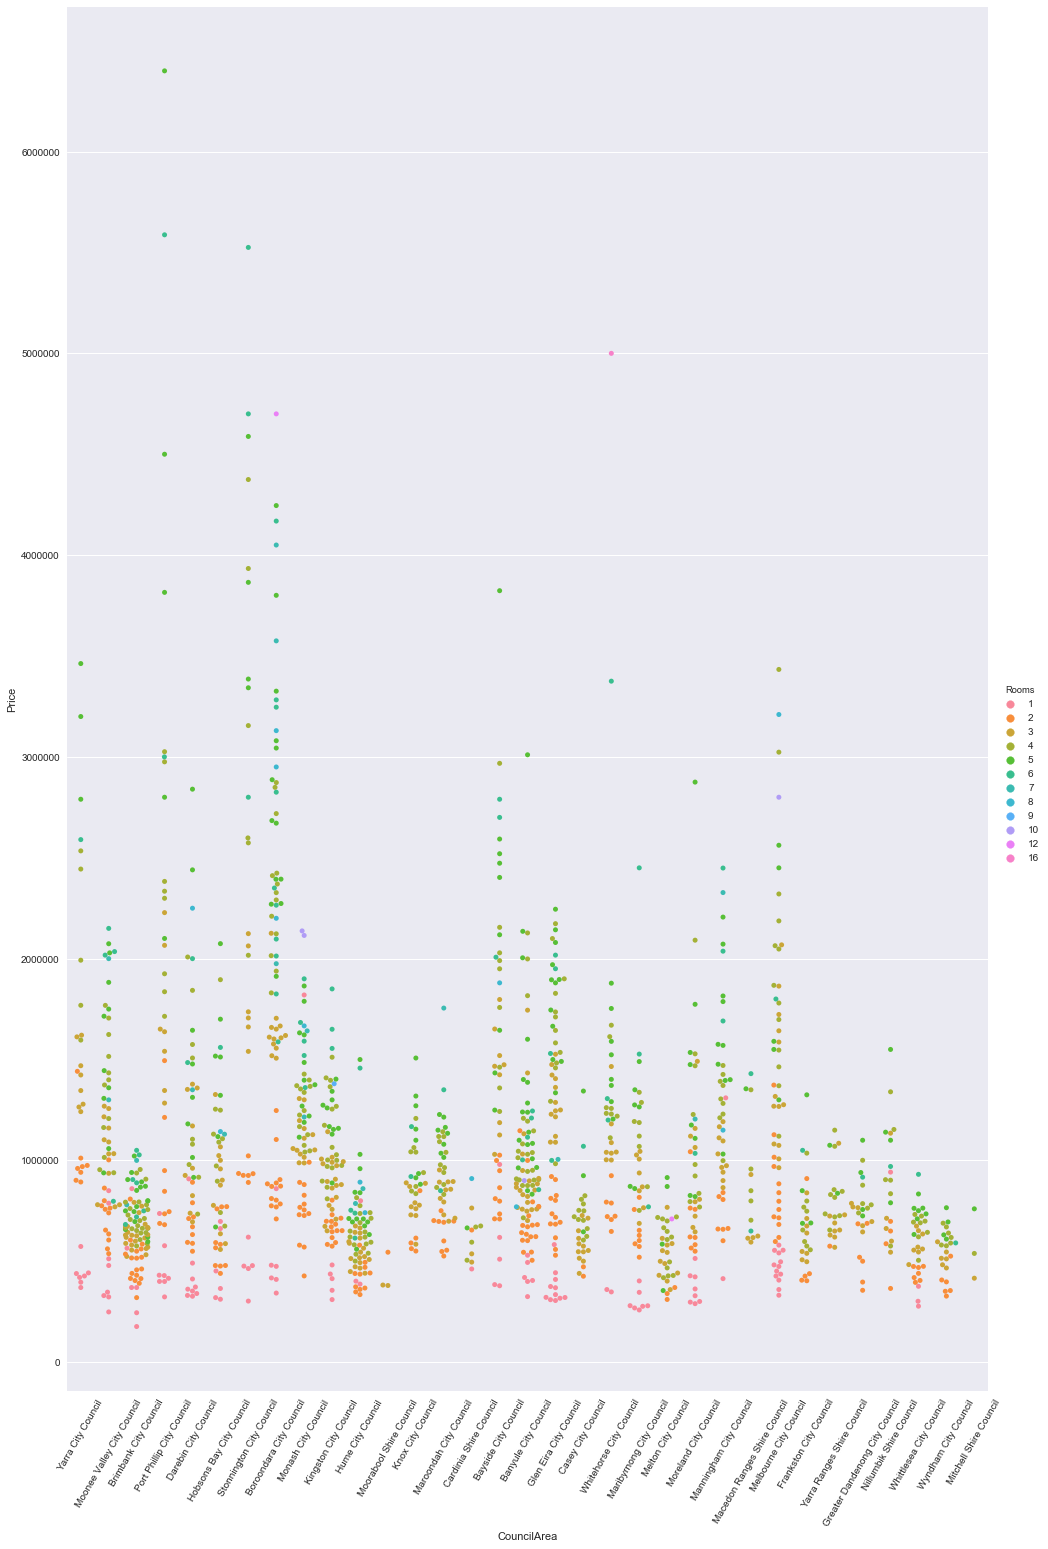

In [85]:
from pandas.io.json import json_normalize
import seaborn as sns
import matplotlib.pyplot as plt
#Price_aggr = features.groupby(['Suburb','Rooms','CouncilArea']).size().rename('count').reset_index()
Price_aggr = features.groupby(['Suburb','Rooms','CouncilArea']).mean().reset_index()
#print(Price_aggr.head())

# Make bee swarm plot
#_ = sns.swarmplot(x='Personality',y='count',hue='industry_type',data=main_aggr,dodge=True)
_ = sns.factorplot(x="CouncilArea", y="Price",
                        hue="Rooms",
                        data=Price_aggr, kind="swarm",
                        size=20, aspect=.7);
for ax in _.axes.flatten(): 
    for tick in ax.get_xticklabels(): 
        tick.set(rotation=60)
#plt.xticks(rotation=45)
# Label axes
#_ = plt.xlabel('Personality')
#_ = plt.ylabel('Involvement')

# Show the plot
plt.show()

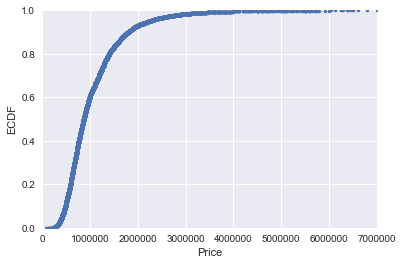

In [86]:
import numpy as np
import pandas as pd

def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)
    # x-data for the ECDF: x
    x = np.sort(data)
    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n
    return x, y

price = features.Price.values
suburb = features.Suburb.values
# Compute ECDF for versicolor data: x_vers, y_vers
x_vers, y_vers = ecdf(price)

# Generate plot
sns.set()
_ = plt.plot(x_vers,y_vers,marker='.',linestyle='none')

# Make the margins nice
plt.margins(0.02)

# Label the axes
_ = plt.xlabel('Price')
_ = plt.ylabel('ECDF')

plt.axis([0,7000000,0,1])


# Display the plot
plt.show()

Based on the above ECDF/Price plot, we can infer that 95% of the properties have a price tag of 2 Million or more.

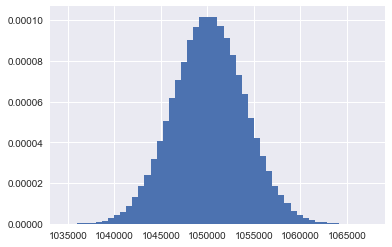

In [87]:
### Draw bootstrap replicates and check whether the plot is normally distributed
def draw_bootstrap(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = func(np.random.choice(data,len(data)))

    return bs_replicates

replicates = draw_bootstrap(price, np.mean, size=100000)
# Make histograms
plt.hist(replicates,normed=True,bins=50)

# Display the plot
plt.show()

The bootstrap replicates appears to be NORMALLY DISTRIBUTED

In [88]:
# Compute the 95% confidence interval: conf_int
conf_int = np.percentile(replicates,[2.5, 97.5])
print('95% Confidence interval is :', conf_int)
print('Mean price is :',np.mean(price))

95% Confidence interval is : [1042586.56848827 1057782.96100305]
Mean price is : 1050173.344955408


#### Null Hypothesis: Median house prices in Melbourne is greater than 1 Million?

#### One sample T-test

Conduct one Sample T-test to check whether the null hypothesis holds True.

In [94]:
from scipy.stats import ttest_1samp

price_mean = np.mean(price)
tset, pval = ttest_1samp(price, 1000000)
print("p-values",float(pval))


if pval < 0.05:    # alpha value is 0.05 or 5%
   print(" we are rejecting null hypothesis")
else:
  print("we are accepting null hypothesis")

p-values 5.048964315474022e-38
 we are rejecting null hypothesis


#### Executing a Z-test

In [95]:
from scipy import stats
from statsmodels.stats import weightstats as stests
ztest ,pval = stests.ztest(price, x2=None, value=1000000)
print(float(pval))
if pval<0.05:
    print("reject null hypothesis")
else:
    print("accept null hypothesis")

3.90484851309094e-38
reject null hypothesis


#### Inference:

Based on the test results of One sample T-Test and Z-Test, we are rejecting the null hypothesis and accepting the 
Alternate hypothesis that median value of housing prices may not be greater than 1 million.